
https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields

https://www.kaggle.com/artgor/nn-baseline

https://www.kaggle.com/ogrellier/user-level-lightgbm-lb-1-4480

https://www.kaggle.com/dimitreoliveira/deep-learning-keras-ga-revenue-prediction


# parse CSV

In [2]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder

path = '../data/'
print(os.listdir(path))

['test_adj.csv', 'test_dropped.csv', 'train_dropped.csv', 'user_test.csv', 'train_orig.csv', 'test_parsed.csv', 'user_test_n.csv', 'train_parsed.csv', 'train_adj.csv', 'test_orig.csv', 'user_train.csv', 'user_train_n.csv']


In [2]:
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [5]:
%%time
df_train = load_df(path + 'train_orig.csv')
df_test = load_df(path + 'test_orig.csv')

df_train.to_csv(path + 'train_parsed.csv')
df_test.to_csv(path + 'test_parsed.csv')

CPU times: user 1min 47s, sys: 3.06 s, total: 1min 50s
Wall time: 1min 50s


# drop columns

In [3]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder

path = '../data/'
print(os.listdir(path))

['test_adj.csv', 'test_dropped.csv', 'train_dropped.csv', 'user_test.csv', 'train_orig.csv', 'test_parsed.csv', 'user_test_n.csv', 'train_parsed.csv', 'train_adj.csv', 'test_orig.csv', 'user_train.csv', 'user_train_n.csv']


In [27]:
%%time
df_train = pd.read_csv(path +'train_parsed.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_test = pd.read_csv(path +'test_parsed.csv', index_col = 0, dtype={'fullVisitorId': 'str'})

<string>:2: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 21.9 s, sys: 852 ms, total: 22.8 s
Wall time: 22.4 s


## Align total # of colums

In [28]:
print(df_train.shape, df_test.shape, )

(903653, 55) (804684, 53)


In [29]:
%%time
df_train, df_test = df_train.align(df_test, join='outer', axis=1)

CPU times: user 417 ms, sys: 188 ms, total: 606 ms
Wall time: 604 ms


In [30]:
print(df_train.shape, df_test.shape, )

(903653, 55) (804684, 55)


## determine columns to drop

In [35]:
%%time

cols_not_unique = [col for col in df_train.columns if df_train[col].nunique() < 2]

cols_null_ratio_high = [col for col in df_train.columns if sum(df_train[col].isnull()) / len(df_train) >= 0.6]

cols_not_much_var = []
df_num = df_train.select_dtypes(include=[np.number])
df_var = df_num.var()
for x in df_num:
    if df_var[x] <= 30:
        cols_not_much_var.append(x)


print('not unique')
print(cols_not_unique)
print()
print('high null ratio')
print(cols_null_ratio_high)
print()
print('not much variance')
print(cols_not_much_var)


not unique
['adwordsClickInfo.criteriaParameters', 'adwordsClickInfo.isVideoAd', 'bounces', 'browserSize', 'browserVersion', 'campaignCode', 'cityId', 'flashVersion', 'isTrueDirect', 'language', 'latitude', 'longitude', 'mobileDeviceBranding', 'mobileDeviceInfo', 'mobileDeviceMarketingName', 'mobileDeviceModel', 'mobileInputSelector', 'networkLocation', 'newVisits', 'operatingSystemVersion', 'screenColors', 'screenResolution', 'socialEngagementType', 'visits']

high null ratio
['adContent', 'adwordsClickInfo.adNetworkType', 'adwordsClickInfo.gclId', 'adwordsClickInfo.isVideoAd', 'adwordsClickInfo.page', 'adwordsClickInfo.slot', 'campaignCode', 'isTrueDirect', 'referralPath', 'transactionRevenue']

not much variance
['adwordsClickInfo.page', 'bounces', 'newVisits', 'visits']
CPU times: user 4.85 s, sys: 43.6 ms, total: 4.89 s
Wall time: 4.57 s


In [112]:
keep_cols = ['fullVisitorId','transactionRevenue','isTrueDirect',
             'adwordsClickInfo.adNetworkType','adwordsClickInfo.isVideoAd','adwordsClickInfo.page',
             'adwordsClickInfo.slot']

del_cols = []
del_cols.extend(cols_not_unique)
del_cols.extend(cols_null_ratio_high)
del_cols.extend(cols_not_much_var)
del_cols = list(set(del_cols))

del_cols = [x for x in del_cols if x not in keep_cols]

print(del_cols)

['mobileInputSelector', 'socialEngagementType', 'screenResolution', 'visits', 'language', 'mobileDeviceModel', 'browserVersion', 'screenColors', 'mobileDeviceMarketingName', 'newVisits', 'adwordsClickInfo.criteriaParameters', 'adContent', 'mobileDeviceInfo', 'longitude', 'operatingSystemVersion', 'cityId', 'referralPath', 'mobileDeviceBranding', 'campaignCode', 'browserSize', 'flashVersion', 'latitude', 'adwordsClickInfo.gclId', 'networkLocation', 'bounces']


In [113]:
df_train.drop(del_cols, axis=1, inplace=True)
df_test.drop(del_cols, axis=1, inplace=True)

In [114]:
print(df_train.shape, df_test.shape, )

(903653, 30) (804684, 30)


In [115]:
%%time
df_train = df_train.fillna(0)
df_train.replace(to_replace=np.nan, value=0, inplace=True)

df_test = df_test.fillna(0)
df_test.replace(to_replace=np.nan, value=0, inplace=True)

df_train.to_csv(path + 'train_dropped.csv')
df_test.to_csv(path + 'test_dropped.csv')

CPU times: user 29.2 s, sys: 1.17 s, total: 30.4 s
Wall time: 30.2 s


# process columns

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder

path = '../data/'
print(os.listdir(path))

['test_adj.csv', 'test_dropped.csv', 'train_dropped.csv', 'user_test.csv', 'train_orig.csv', 'test_parsed.csv', 'user_test_n.csv', 'train_parsed.csv', 'train_adj.csv', 'test_orig.csv', 'user_train.csv', 'user_train_n.csv']


In [2]:
%%time
df_train = pd.read_csv(path +'train_dropped.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_test = pd.read_csv(path +'test_dropped.csv', index_col = 0, dtype={'fullVisitorId': 'str'})

CPU times: user 9.28 s, sys: 501 ms, total: 9.78 s
Wall time: 9.47 s


## only for train dataset

In [3]:
# to float and log
df_train['transactionRevenue'] = df_train['transactionRevenue'].astype(float)
df_train['transactionRevenue'] = np.log1p(df_train['transactionRevenue'].fillna(0))


## to both train and test datasets

In [4]:
print(df_train.shape,df_test.shape)
print(df_train.columns)

(903653, 30) (804684, 30)
Index(['adwordsClickInfo.adNetworkType', 'adwordsClickInfo.isVideoAd',
       'adwordsClickInfo.page', 'adwordsClickInfo.slot', 'browser', 'campaign',
       'channelGrouping', 'city', 'continent', 'country', 'date',
       'deviceCategory', 'fullVisitorId', 'hits', 'isMobile', 'isTrueDirect',
       'keyword', 'medium', 'metro', 'networkDomain', 'operatingSystem',
       'pageviews', 'region', 'sessionId', 'source', 'subContinent',
       'transactionRevenue', 'visitId', 'visitNumber', 'visitStartTime'],
      dtype='object')


### trim items too minor

In [5]:
def grpMinorItems(df, col, N):
    l_top = df[col].value_counts().index[:N].tolist()
    df[col] = df[col].apply(lambda x: x if x in l_top else col + '_minor')
    return df

In [6]:
%%time
n_top = 5
l_col = []
dont_touch = ['fullVisitorId','sessionId']

for x in df_train.select_dtypes('object').columns:
    if len(df_train[x].value_counts().index) > n_top:
        l_col.append(x)

l_col = [x for x in l_col if x not in dont_touch]
print(l_col)

['browser', 'campaign', 'channelGrouping', 'city', 'continent', 'country', 'keyword', 'medium', 'metro', 'networkDomain', 'operatingSystem', 'region', 'source', 'subContinent']
CPU times: user 3.56 s, sys: 56.2 ms, total: 3.62 s
Wall time: 3.19 s


In [57]:
%%time
for x in l_col:
    df_train = grpMinorItems(df_train,x,n_top)
    df_test = grpMinorItems(df_test,x,n_top)


CPU times: user 7.42 s, sys: 55.4 ms, total: 7.47 s
Wall time: 7.48 s


In [59]:
df_train.nunique()

adwordsClickInfo.adNetworkType         3
adwordsClickInfo.isVideoAd             2
adwordsClickInfo.page                  9
adwordsClickInfo.slot                  3
browser                                6
campaign                               6
channelGrouping                        6
city                                   6
continent                              6
country                                6
date                                 366
deviceCategory                         3
fullVisitorId                     714167
hits                                 274
isMobile                               2
isTrueDirect                           2
keyword                                6
medium                                 6
metro                                  6
networkDomain                          6
operatingSystem                        6
pageviews                            214
region                                 6
sessionId                         902755
source          

### manually delete columns

In [60]:
%%time

del_cols = ['sessionId','visitId','visitStartTime']

for x in del_cols:
    df_train.drop(x, axis=1, inplace=True)
    df_test.drop(x, axis=1, inplace=True)


CPU times: user 704 ms, sys: 192 ms, total: 896 ms
Wall time: 895 ms


In [61]:
print(df_train.shape,df_test.shape)

(903653, 27) (804684, 27)


### analyze date

In [62]:
%%time
def dateCol(df):

    df['date'] = pd.to_datetime(df['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.weekday
    df['weekend'] = df['weekday'].apply(lambda x: 1 if x>=5 else 0)
    
    return df

df_train = dateCol(df_train)
df_test = dateCol(df_test)

CPU times: user 3.26 s, sys: 56 ms, total: 3.32 s
Wall time: 2.59 s


### access count column

In [63]:
%%time
def userCount(df):
    df['cnt_per_day'] = df[['fullVisitorId','date']].groupby(['fullVisitorId','date'])['date'].transform('count')
    return df

df_train = userCount(df_train)
df_test = userCount(df_test)

CPU times: user 3.55 s, sys: 27.8 ms, total: 3.58 s
Wall time: 2.99 s


### category string to numbers

In [64]:
no_touch = ['fullVisitorId','transactionRevenue']
cat_cols = [x for x in df_train.columns if df_train[x].dtypes == 'object' or df_train[x].dtypes == 'bool']
cat_cols = [x for x in cat_cols if df_train[x].nunique() <= 100]
cat_cols = [x for x in cat_cols if x not in no_touch]

cat_cols

['adwordsClickInfo.adNetworkType',
 'adwordsClickInfo.isVideoAd',
 'adwordsClickInfo.slot',
 'browser',
 'campaign',
 'channelGrouping',
 'city',
 'continent',
 'country',
 'deviceCategory',
 'isMobile',
 'isTrueDirect',
 'keyword',
 'medium',
 'metro',
 'networkDomain',
 'operatingSystem',
 'region',
 'source',
 'subContinent']

In [65]:
%%time

for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(df_train[col].values.astype('str')) + list(df_test[col].values.astype('str')))
    df_train[col] = lbl.transform(list(df_train[col].values.astype('str')))
    df_test[col] = lbl.transform(list(df_test[col].values.astype('str')))


CPU times: user 1min 24s, sys: 10 s, total: 1min 34s
Wall time: 1min 14s


In [66]:
%%time
l = {}
for x in df_train.columns:
    l[x] = x.replace(' ','').replace('(','').replace(')','').replace('-','')[:20]

df_train = df_train.rename(columns=l)
df_test = df_test.rename(columns=l)



CPU times: user 378 ms, sys: 576 ms, total: 955 ms
Wall time: 481 ms


In [67]:
no_touch = ['fullVisitorId','transactionRevenue','date']
l_float = [x for x in df_train.columns if x not in no_touch]
l_float

['adwordsClickInfo.adN',
 'adwordsClickInfo.isV',
 'adwordsClickInfo.pag',
 'adwordsClickInfo.slo',
 'browser',
 'campaign',
 'channelGrouping',
 'city',
 'continent',
 'country',
 'deviceCategory',
 'hits',
 'isMobile',
 'isTrueDirect',
 'keyword',
 'medium',
 'metro',
 'networkDomain',
 'operatingSystem',
 'pageviews',
 'region',
 'source',
 'subContinent',
 'visitNumber',
 'month',
 'weekday',
 'weekend',
 'cnt_per_day']

In [68]:
%%time

df_train[l_float] = df_train[l_float].values.astype('float')
df_test[l_float] = df_test[l_float].values.astype('float')

CPU times: user 9.11 s, sys: 2.38 s, total: 11.5 s
Wall time: 6.26 s


In [69]:
df_train.shape, df_test.shape

((903653, 31), (804684, 31))

### save adjusted DFs

In [70]:
%%time
df_train.to_csv(path + 'train_adj.csv')
df_test.to_csv(path + 'test_adj.csv')

CPU times: user 33.1 s, sys: 278 ms, total: 33.4 s
Wall time: 33.5 s


In [71]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 903653 entries, 0 to 903652
Data columns (total 31 columns):
adwordsClickInfo.adN    903653 non-null float64
adwordsClickInfo.isV    903653 non-null float64
adwordsClickInfo.pag    903653 non-null float64
adwordsClickInfo.slo    903653 non-null float64
browser                 903653 non-null float64
campaign                903653 non-null float64
channelGrouping         903653 non-null float64
city                    903653 non-null float64
continent               903653 non-null float64
country                 903653 non-null float64
date                    903653 non-null datetime64[ns]
deviceCategory          903653 non-null float64
fullVisitorId           903653 non-null object
hits                    903653 non-null float64
isMobile                903653 non-null float64
isTrueDirect            903653 non-null float64
keyword                 903653 non-null float64
medium                  903653 non-null float64
metro              

# create new dataset: aggregated by users

In [72]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder

path = '../data/'
print(os.listdir(path))

['test_adj.csv', 'test_dropped.csv', 'train_dropped.csv', 'user_test.csv', 'train_orig.csv', 'test_parsed.csv', 'user_test_n.csv', 'train_parsed.csv', 'train_adj.csv', 'test_orig.csv', 'user_train.csv', 'user_train_n.csv']


In [73]:
%%time
df_train = pd.read_csv(path +'train_adj.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_test = pd.read_csv(path +'test_adj.csv', index_col = 0, dtype={'fullVisitorId': 'str'})

CPU times: user 5.23 s, sys: 320 ms, total: 5.55 s
Wall time: 5.23 s


In [74]:
df_train.shape, df_test.shape

((903653, 31), (804684, 31))

In [75]:
def statCols(df):
    df['access_Days'] = df.groupby(['fullVisitorId','date'])['date'].transform('count')
    
    df['avg_hitperDay'] = df.groupby(['fullVisitorId','date'])['hits'].transform('mean')
    df['ttl_hitbyUser'] = df.groupby(['fullVisitorId'])['hits'].transform('sum')

    df['avg_viewperDay'] = df.groupby(['fullVisitorId','date'])['pageviews'].transform('mean')
    df['ttl_viewbyUser'] = df.groupby(['fullVisitorId'])['pageviews'].transform('sum')

    return df

In [76]:
%%time
df_train = statCols(df_train)
df_test = statCols(df_test)

CPU times: user 17.2 s, sys: 876 ms, total: 18 s
Wall time: 14.8 s


In [77]:
df_train.describe()

,adwordsClickInfo.adN,adwordsClickInfo.isV,adwordsClickInfo.pag,adwordsClickInfo.slo,browser,campaign,channelGrouping,city,continent,country,...,visitNumber,month,weekday,weekend,cnt_per_day,access_Days,avg_hitperDay,ttl_hitbyUser,avg_viewperDay,ttl_viewbyUser
count,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,...,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000
mean,0.047504,0.023748,0.023941,0.070686,2.154672,0.181626,2.795041,4.194165,1.726616,4.643241,...,2.264897,6.987671,2.735183,0.219117,1.193563,1.193563,4.596538,18.775357,3.849338,15.311467
std,0.304589,0.152263,0.155811,0.453814,1.792610,0.878937,1.774419,1.295288,0.888616,1.452390,...,9.283735,3.484576,1.929072,0.413649,0.611397,0.611397,9.027772,123.174505,6.587883,100.218298
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,4.000000,1.000000,4.000000,...,1.000000,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,5.000000,1.000000,4.000000,...,1.000000,7.000000,3.000000,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000
75%,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,5.000000,5.000000,2.000000,6.000000,...,1.000000,10.000000,4.000000,0.000000,1.000000,1.000000,4.000000,9.000000,4.000000,8.000000
max,3.000000,1.000000,14.000000,3.000000,6.000000,7.000000,6.000000,5.000000,5.000000,6.000000,...,395.000000,12.000000,6.000000,1.000000,32.000000,32.000000,500.000000,4995.000000,466.000000,4160.000000


In [78]:
def aggregate_by_users(df):
    users = df.groupby(['fullVisitorId']).agg('mean')
    users['transactionRevenue'] = df.groupby(['fullVisitorId'])['transactionRevenue'].agg('sum')
    users['hits'] = df.groupby(['fullVisitorId'])['hits'].agg('sum')
    users['pageviews'] = df.groupby(['fullVisitorId'])['pageviews'].agg('sum')
    users['month_min'] = df.groupby(['fullVisitorId'])['month'].agg('min')
    users['month_max'] = df.groupby(['fullVisitorId'])['month'].agg('max')
    users['weekend_min'] = df.groupby(['fullVisitorId'])['weekend'].agg('min')
    users['weekend_max'] = df.groupby(['fullVisitorId'])['weekend'].agg('max')
    return users


In [79]:
%%time

df_test['transactionRevenue'] = 0

df_user_train = aggregate_by_users(df_train)
df_user_test = aggregate_by_users(df_test)


CPU times: user 25.4 s, sys: 1.04 s, total: 26.4 s
Wall time: 22.5 s


In [80]:
print(df_train.shape,df_test.shape)
print(df_train.fullVisitorId.nunique(),df_test.fullVisitorId.nunique())
print(df_user_train.shape,df_user_test.shape)


(903653, 36) (804684, 36)
714167 617242
(714167, 38) (617242, 38)


In [81]:
df_user_train.describe()

,adwordsClickInfo.adN,adwordsClickInfo.isV,adwordsClickInfo.pag,adwordsClickInfo.slo,browser,campaign,channelGrouping,city,continent,country,...,cnt_per_day,access_Days,avg_hitperDay,ttl_hitbyUser,avg_viewperDay,ttl_viewbyUser,month_min,month_max,weekend_min,weekend_max
count,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,...,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000
mean,0.039874,0.019934,0.020129,0.059227,2.274657,0.163012,2.870280,4.263621,1.786760,4.716682,...,1.066602,1.066602,3.917565,5.816112,3.340949,4.870662,6.983504,7.108938,0.215469,0.246599
std,0.270933,0.135441,0.139650,0.402953,1.845788,0.816637,1.775531,1.254160,0.896831,1.472815,...,0.289029,0.289029,7.276184,18.417008,5.350892,14.128870,3.487806,3.471920,0.411148,0.431032
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,4.000000,1.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,5.000000,2.000000,5.000000,...,1.000000,1.000000,1.500000,2.000000,1.333333,2.000000,7.000000,7.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,5.000000,5.000000,3.000000,6.000000,...,1.000000,1.000000,4.000000,4.000000,3.000000,4.000000,10.000000,10.000000,0.000000,0.000000
max,3.000000,1.000000,14.000000,3.000000,6.000000,7.000000,6.000000,5.000000,5.000000,6.000000,...,27.918919,27.918919,500.000000,4995.000000,466.000000,4160.000000,12.000000,12.000000,1.000000,1.000000


In [86]:
%%time
df_user_train = df_user_train.fillna(0)
df_user_test = df_user_test.fillna(0)

df_user_train.to_csv(path + 'user_train.csv')
df_user_test.to_csv(path + 'user_test.csv')

CPU times: user 28.1 s, sys: 468 ms, total: 28.6 s
Wall time: 28.2 s


# Normalize

In [87]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

path = '../data/'
print(os.listdir(path))

['test_adj.csv', 'test_dropped.csv', 'train_dropped.csv', 'user_test.csv', 'train_orig.csv', 'test_parsed.csv', 'user_test_n.csv', 'train_parsed.csv', 'train_adj.csv', 'test_orig.csv', 'user_train.csv', 'user_train_n.csv']


In [88]:
%%time
df_user_train = pd.read_csv(path +'user_train.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_user_test = pd.read_csv(path +'user_test.csv', index_col = 0, dtype={'fullVisitorId': 'str'})


CPU times: user 5.34 s, sys: 192 ms, total: 5.53 s
Wall time: 5.23 s


In [89]:
print(df_user_train.shape,df_user_test.shape)
print(df_user_train.columns)

(714167, 38) (617242, 38)
Index(['adwordsClickInfo.adN', 'adwordsClickInfo.isV', 'adwordsClickInfo.pag',
       'adwordsClickInfo.slo', 'browser', 'campaign', 'channelGrouping',
       'city', 'continent', 'country', 'deviceCategory', 'hits', 'isMobile',
       'isTrueDirect', 'keyword', 'medium', 'metro', 'networkDomain',
       'operatingSystem', 'pageviews', 'region', 'source', 'subContinent',
       'transactionRevenue', 'visitNumber', 'month', 'weekday', 'weekend',
       'cnt_per_day', 'access_Days', 'avg_hitperDay', 'ttl_hitbyUser',
       'avg_viewperDay', 'ttl_viewbyUser', 'month_min', 'month_max',
       'weekend_min', 'weekend_max'],
      dtype='object')


In [90]:
%%time

tgt = [x for x in df_user_train.columns if x not in ['fullVisitorId','transactionRevenue'] ]

sc = MinMaxScaler()
df_user_train[tgt] = sc.fit_transform(df_user_train[tgt])
df_user_test[tgt] = sc.transform(df_user_test[tgt])

CPU times: user 4.59 s, sys: 977 ms, total: 5.56 s
Wall time: 2.99 s


In [91]:
df_user_train.describe()

,adwordsClickInfo.adN,adwordsClickInfo.isV,adwordsClickInfo.pag,adwordsClickInfo.slo,browser,campaign,channelGrouping,city,continent,country,...,cnt_per_day,access_Days,avg_hitperDay,ttl_hitbyUser,avg_viewperDay,ttl_viewbyUser,month_min,month_max,weekend_min,weekend_max
count,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,...,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000,714167.000000
mean,0.013291,0.019934,0.001438,0.019742,0.254931,0.023287,0.478380,0.852724,0.357352,0.786114,...,0.002474,0.002474,0.005847,0.000964,0.007169,0.001171,0.543955,0.555358,0.215469,0.246599
std,0.090311,0.135441,0.009975,0.134318,0.369158,0.116662,0.295922,0.250832,0.179366,0.245469,...,0.010737,0.010737,0.014582,0.003688,0.011483,0.003396,0.317073,0.315629,0.411148,0.431032
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.800000,0.200000,0.666667,...,0.000000,0.000000,0.000000,0.000000,0.002146,0.000240,0.272727,0.272727,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,1.000000,0.400000,0.833333,...,0.000000,0.000000,0.001002,0.000200,0.002861,0.000481,0.545455,0.545455,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.800000,0.000000,0.833333,1.000000,0.600000,1.000000,...,0.000000,0.000000,0.006012,0.000601,0.006438,0.000962,0.818182,0.818182,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [92]:
%%time
df_user_train.to_csv(path + 'user_train_n.csv')
df_user_test.to_csv(path + 'user_test_n.csv')

CPU times: user 39.1 s, sys: 495 ms, total: 39.6 s
Wall time: 40.4 s


# visualize correlations

In [93]:
%%time
df_user_train = pd.read_csv(path +'user_train.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_user_train.drop('transactionRevenue', axis = 1, inplace=True)


CPU times: user 2.98 s, sys: 136 ms, total: 3.12 s
Wall time: 2.96 s


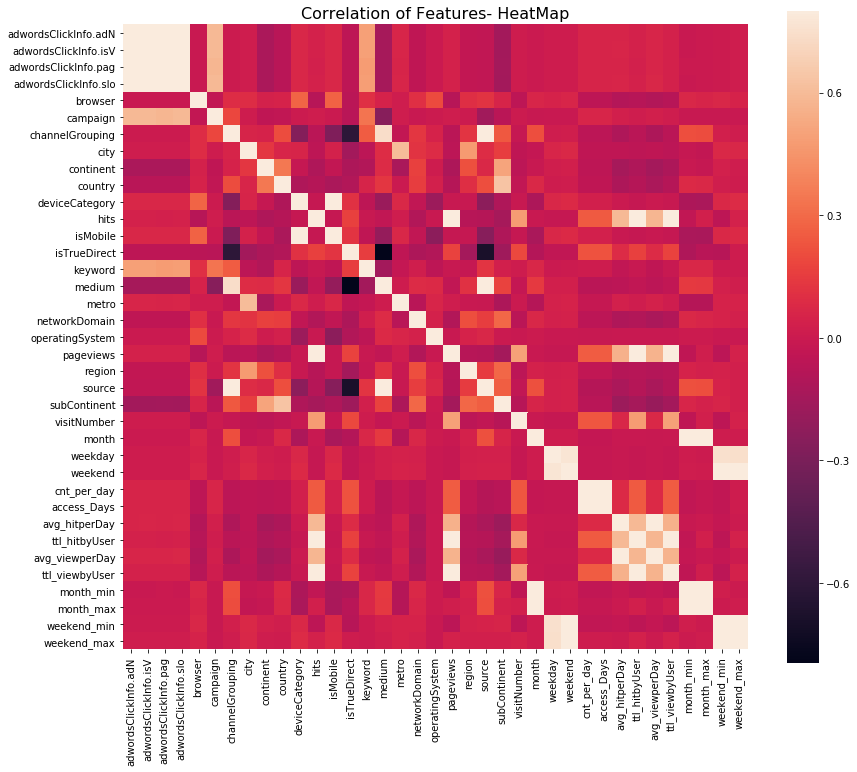

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

f , ax = plt.subplots(figsize = (14,12))
plt.title('Correlation of Features- HeatMap',y=1,size=16)
sns.heatmap(df_user_train.corr(),square = True,  vmax=0.8)
